<a href="https://colab.research.google.com/github/TahseenNoor/water-quality-app/blob/main/water_quality_model(RRN_194%2C152).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy==0.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894076 sha256=339d4de8ec923c134f8e6e8737fc3fd33c3d80f6c9a834ae3f97d88404ece057
  Stored in directory: /root/.cache/pip/wheels/b1/67/d1/6c29aeb1cd2d36447ad5b0de027580b8894aff702a9b50041e
Successfully built scikit-fuzzy


Synthetic dataset saved as water_quality_data.csv


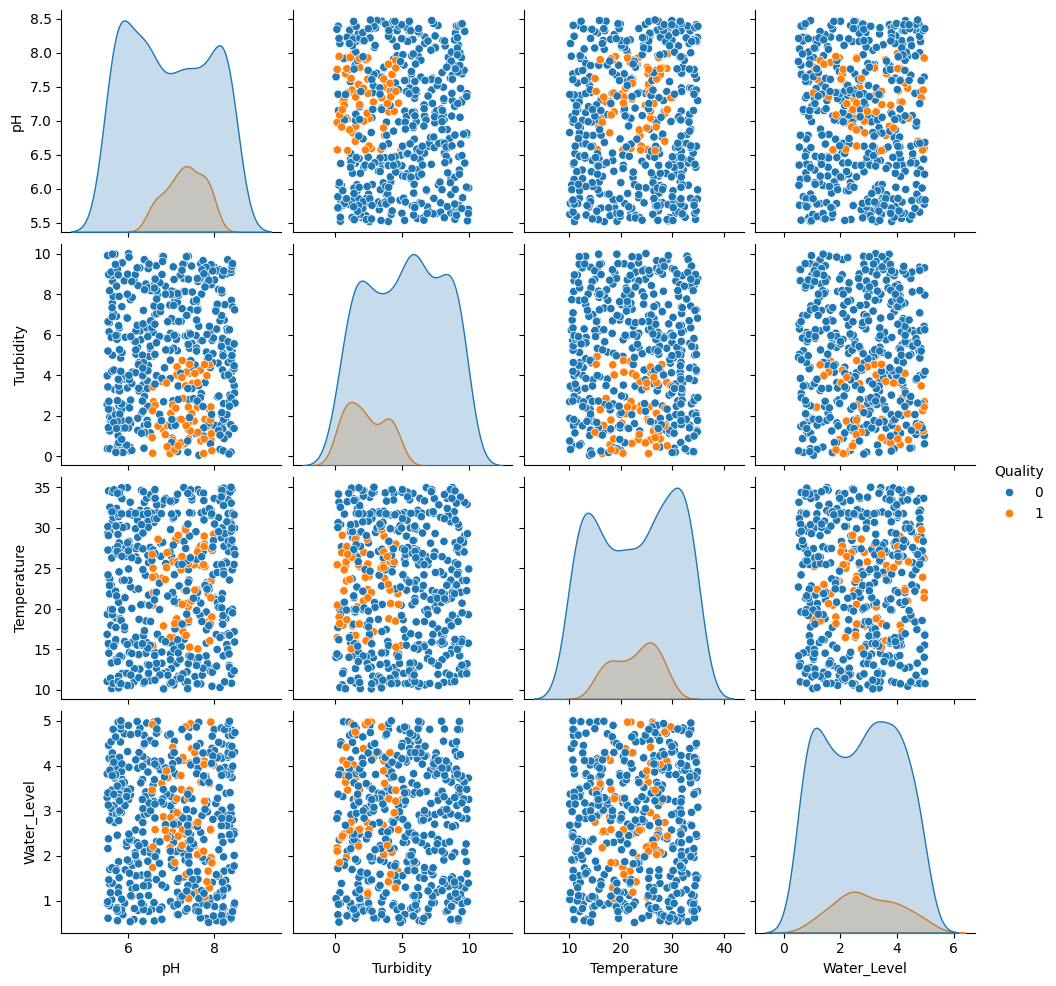

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6399 - loss: 0.6584 - val_accuracy: 0.9200 - val_loss: 0.4268
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8530 - loss: 0.4278 - val_accuracy: 0.9200 - val_loss: 0.2534
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8756 - loss: 0.3442 - val_accuracy: 0.9200 - val_loss: 0.2557
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8890 - loss: 0.2930 - val_accuracy: 0.9200 - val_loss: 0.2375
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8769 - loss: 0.2987 - val_accuracy: 0.9200 - val_loss: 0.2216
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8683 - loss: 0.2797 - val_accuracy: 0.9200 - val_loss: 0.2203
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8536 - loss: 0.2863 - val_accuracy: 0.9200 - val_loss: 0.2145
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8499 - loss: 0.2732 - val_accuracy: 0.9200 - val_loss

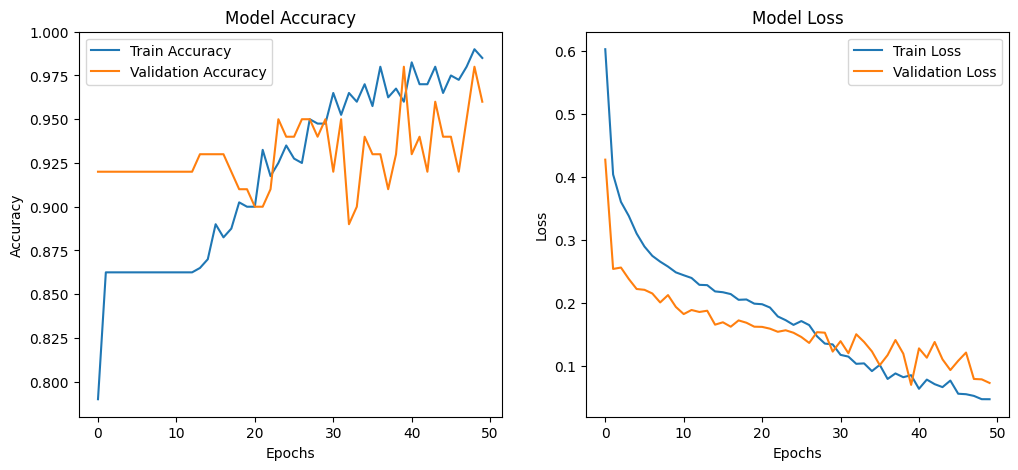

Predicted Water Quality:  0.8611111111111113


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic dataset
def generate_synthetic_data(n_samples=500):
    np.random.seed(42)
    pH = np.random.uniform(5.5, 8.5, n_samples)
    turbidity = np.random.uniform(0, 10, n_samples)
    temp = np.random.uniform(10, 35, n_samples)
    water_level = np.random.uniform(0.5, 5, n_samples)

    quality = np.where((pH >= 6.5) & (pH <= 8) & (turbidity < 5) & (temp >= 15) & (temp <= 30) & (water_level > 1), 1, 0)

    df = pd.DataFrame({
        'pH': pH,
        'Turbidity': turbidity,
        'Temperature': temp,
        'Water_Level': water_level,
        'Quality': quality
    })
    df.to_csv("water_quality_data.csv", index=False)
    print("Synthetic dataset saved as water_quality_data.csv")

generate_synthetic_data()

# Load dataset
dataset_path = "water_quality_data.csv"
df = pd.read_csv(dataset_path)

# Visualizing dataset distribution
sns.pairplot(df, hue='Quality', diag_kind='kde')
plt.show()

# Assume the dataset has sensor readings as features and 'quality' as the target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Define ET-DNN Model
def build_et_dnn(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_shape,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_et_dnn(X.shape[1])

# Train model
history = model.fit(X, y, epochs=50, batch_size=16, validation_split=0.2)

# Plot training accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Define Fuzzy Logic System
ph = ctrl.Antecedent(np.arange(0, 14, 0.1), 'pH')
turbidity = ctrl.Antecedent(np.arange(0, 10, 0.1), 'Turbidity')
temp = ctrl.Antecedent(np.arange(10, 35, 0.5), 'Temperature')
water_level = ctrl.Antecedent(np.arange(0.5, 5, 0.1), 'Water_Level')
quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Quality')

# Define fuzzy membership functions
ph['low'] = fuzz.trimf(ph.universe, [0, 3, 7])
ph['normal'] = fuzz.trimf(ph.universe, [6, 7, 8])
ph['high'] = fuzz.trimf(ph.universe, [7, 11, 14])

turbidity['low'] = fuzz.trimf(turbidity.universe, [0, 2, 5])
turbidity['high'] = fuzz.trimf(turbidity.universe, [4, 7, 10])

temp['cold'] = fuzz.trimf(temp.universe, [10, 15, 20])
temp['moderate'] = fuzz.trimf(temp.universe, [18, 25, 30])
temp['hot'] = fuzz.trimf(temp.universe, [28, 32, 35])

water_level['low'] = fuzz.trimf(water_level.universe, [0.5, 1, 2])
water_level['medium'] = fuzz.trimf(water_level.universe, [1.5, 2.5, 3.5])
water_level['high'] = fuzz.trimf(water_level.universe, [3, 4, 5])

quality['poor'] = fuzz.trimf(quality.universe, [0, 0.3, 0.5])
quality['average'] = fuzz.trimf(quality.universe, [0.4, 0.6, 0.8])
quality['good'] = fuzz.trimf(quality.universe, [0.7, 0.9, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(ph['low'] | turbidity['high'] | temp['cold'], quality['poor'])
rule2 = ctrl.Rule(ph['normal'] & turbidity['low'] & temp['moderate'] & water_level['medium'], quality['good'])
rule3 = ctrl.Rule(ph['high'] & turbidity['low'] & temp['hot'], quality['average'])

quality_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)

# Example inference
quality_sim.input['pH'] = 7.5
quality_sim.input['Turbidity'] = 3.0
quality_sim.input['Temperature'] = 24
quality_sim.input['Water_Level'] = 2.5
quality_sim.compute()
print("Predicted Water Quality: ", quality_sim.output['Quality'])

# Save model for future use
model.save("water_quality_etdnn.h5")


In [ ]:
!pip install numpy pandas matplotlib scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd

# Upload your dataset manually or load from a path
from google.colab import files
uploaded = files.upload()

# Replace with actual file name
df = pd.read_csv("realfishdataset.csv")  # or whatever the file is named
df.head()


Saving realfishdataset.csv to realfishdataset (1).csv


,ph,temperature,turbidity,fish
0,6.0,27.0,4.0,katla
1,7.6,28.0,5.9,sing
2,7.8,27.0,5.5,sing
3,6.5,31.0,5.5,katla
4,8.2,27.0,8.5,prawn


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Features & target (you can choose target like 'Fish species' or simulate DO/BOD etc.)
X = df[['pH', 'Temperature', 'Turbidity']]
y = df['Fish species']  # or create a binary "Safe/Not Safe" label

# Encode labels if needed
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


KeyError: "None of [Index(['pH', 'Temperature', 'Turbidity'], dtype='object')] are in the [columns]"

In [ ]:
print(df.columns)


Index(['ph', 'temperature', 'turbidity', 'fish'], dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Use correct column names
X = df[['ph', 'temperature', 'turbidity']]
y = df['fish']

# Encode target labels (e.g., fish species)
y = LabelEncoder().fit_transform(y)

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ETDFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ETDFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Mimic fuzzy logic behavior
        x = torch.tanh(self.fc1(x))  # fuzzy-ish activation
        x = F.relu(self.fc2(x))      # deep NN behavior
        return self.output(x)

model = ETDFNN(input_size=3, hidden_size=32, output_size=len(set(y)))


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert data to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


Epoch 1 | Loss: 0.0876
Epoch 2 | Loss: 0.1143
Epoch 3 | Loss: 0.0763
Epoch 4 | Loss: 0.1641
Epoch 5 | Loss: 0.3241


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

model.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(X_test_t).argmax(dim=1).numpy()

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {acc * 100:.2f}%")



✅ Model Accuracy: 85.04%


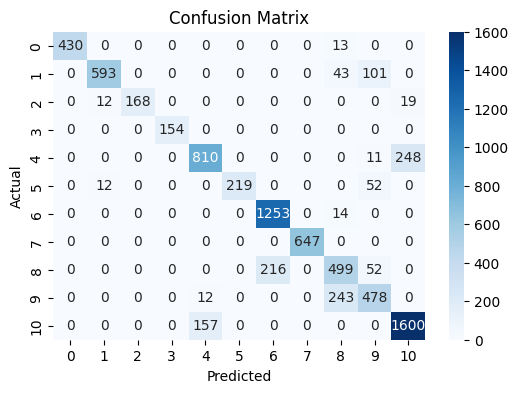

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Saving realfishdataset.csv to realfishdataset (1).csv
Epoch 1 | Loss: 0.0013
Epoch 2 | Loss: 0.0000
Epoch 3 | Loss: 0.0000
Epoch 4 | Loss: 0.0000
Epoch 5 | Loss: 0.0000
Epoch 6 | Loss: 0.0000
Epoch 7 | Loss: 0.0000
Epoch 8 | Loss: 0.0000
Epoch 9 | Loss: 0.0000
Epoch 10 | Loss: 0.0000

✅ Final Accuracy: 100.00%

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8056

    accuracy                           1.00      8056
   macro avg       1.00      1.00      1.00      8056
weighted avg       1.00      1.00      1.00      8056



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


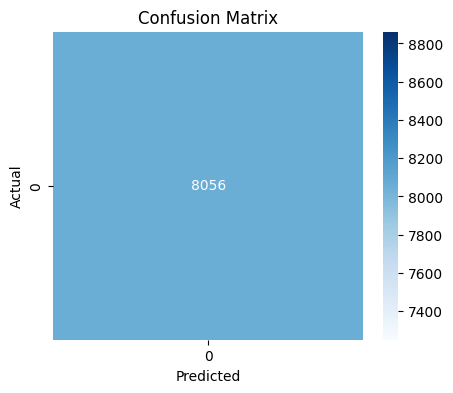

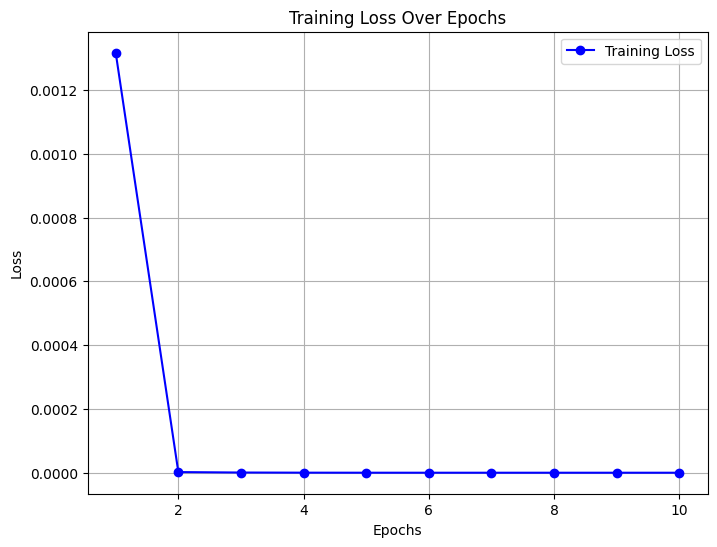

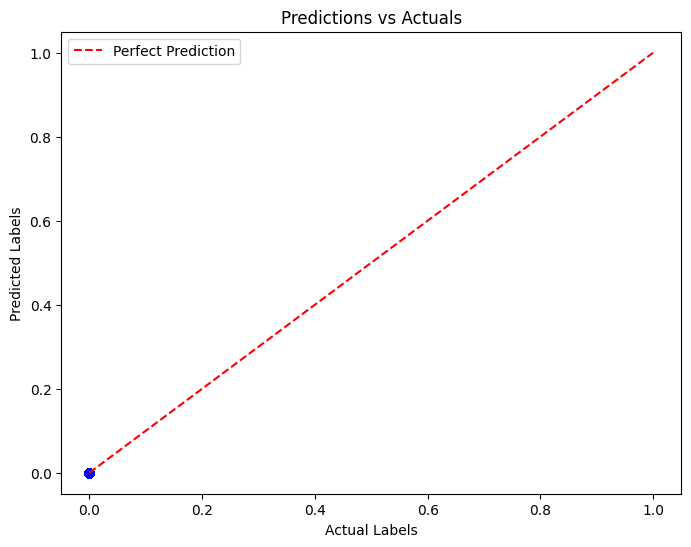

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Upload  dataset
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

# ✅ GROUPING  classes into binary: safe (1) vs unsafe (0)
safe_fish = ['Tilapia', 'Rohu', 'Catla']
df['safe'] = df['fish'].apply(lambda x: 1 if x in safe_fish else 0)

# Features & target
X = df[['ph', 'temperature', 'turbidity']]
y = df['safe']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ Model: Simple, regularized for binary classification
class ETDFNNBinary(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ETDFNNBinary, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)  # Binary output

    def forward(self, x):
        x = torch.tanh(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))  # sigmoid for binary

model = ETDFNNBinary(input_size=3, hidden_size=64)

# Loss & Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

# Prepare DataLoader
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)

# 🏋️ Train the model
train_losses = []  # To store loss over epochs
for epoch in range(10):
    model.train()
    epoch_loss = 0  # Track the loss for each epoch
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  # Accumulate loss

    # Record the average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

# 📈 Evaluation
model.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    y_pred_probs = model(X_test_t).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Accuracy: {acc * 100:.2f}%")

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 📊 Visualizing Loss Over Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# 📊 Visualizing Predictions vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='b', alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.show()


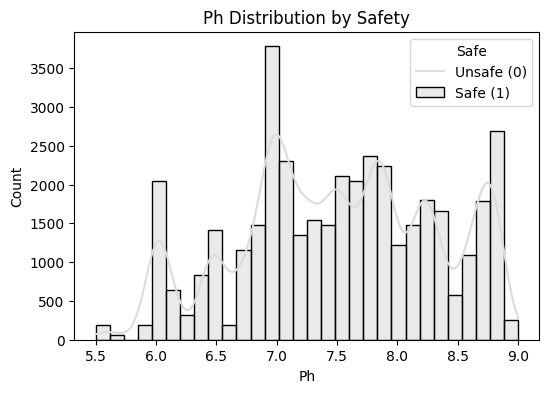

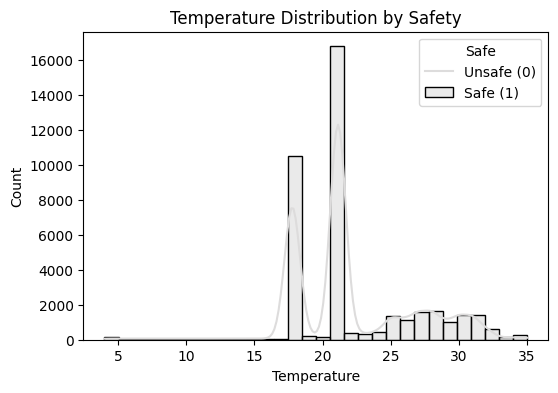

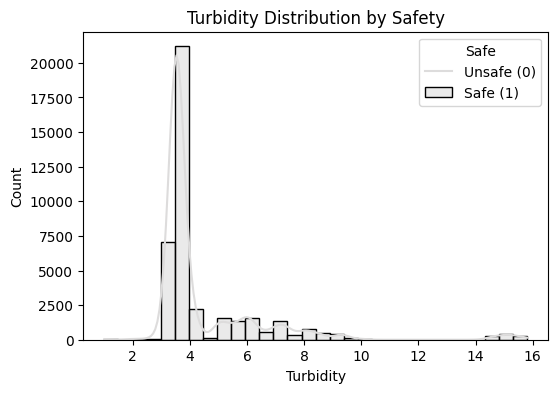

In [4]:
features = ['ph', 'temperature', 'turbidity']
for feature in features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=feature, hue='safe', bins=30, kde=True, palette="coolwarm", alpha=0.6)
    plt.title(f"{feature.capitalize()} Distribution by Safety")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Count")
    plt.legend(title='Safe', labels=['Unsafe (0)', 'Safe (1)'])
    plt.show()
